In [ ]:
import os
import numpy as np
import numpy.random as npr
import scipy.linalg as spl
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from time import perf_counter
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from itertools import count
from tqdm import trange
from utils import *
from state_vae import *

ModuleNotFoundError: No module named 'freyberg_state_vae'

In [ ]:
dtype = torch.float32
if torch.cuda.is_available():
    gpus = [f"cuda:{i}" for i in range(torch.cuda.device_count())]
print(f"Available GPUs: {gpus}")
torch.set_default_dtype(dtype)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'using device:{device}')

rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

normalize = lambda data, vmax, vmin: 2*(data - vmin)/ (vmax - vmin) - 1 # scale data to [-1, 1]
back_normalize = lambda data, vmax, vmin: (data + 1)*(vmax - vmin)/2 + vmin # scale data back

Available GPUs: ['cuda:0', 'cuda:1']
using device:cuda:1


In [ ]:
with h5py.File('./freyberg_tv_data_5000_f32.h5', 'r') as f:
    #print([key for key in f.keys()])
    y_ref = f.get('y_ref')[:]  #(40, 20)
    h_ref = f.get('h_ref')[:-1, ...] #(24, 40, 20)
    y_data = f.get('y_data')[:] #(5000, 40, 20)
    h_data = f.get('h_data')[:, :-1, ...]  #(5000, 24, 40, 20)
    xiY = f.get('xiY')[:] # (5001, 150)
    etah = f.get('etah')[:] # (5001, 90)
    coord_data = f.get('coord_data')[:] 
    h_mean = f.get('h_mean')[:] #(706,)
    Psih = f.get('Psih')[:] #(706, 150)
    lamh = f.get('lamh')[:] #(706)

In [ ]:
Nx = 20
Ny = 40
Nt = 24
Ncells_raw = Nx * Ny
Ncells = 706
Ntrain = 4950
latent_dim = 90
epochs = 1000
num_print = 10
batch_size = 64
gamma = 1e-4
lr = 1e-4

print('Latent space dimension: {}\n'.format(latent_dim))
print('regularization gamma: {}\n'.format(gamma))

h_train = h_data[:Ntrain, :, :] 
h_test = h_data[Ntrain:, :, :] 
Ntrain = h_train.shape[0]
Ntest = h_test.shape[0]
mask = ~(np.isnan(y_ref)) #(Ny, Nx)
mask_t = np.tile(mask, (Nt, 1, 1)) #(Nt, Ny, Nx)
mask_rep_t_batch = lambda x: np.tile(mask_t, (x.shape[0], 1, 1, 1)) # return (Nbatch, Nt, Ny, Nx)

h_train_max = h_train[mask_rep_t_batch(h_train)].max()
h_train_min = h_train[mask_rep_t_batch(h_train)].min()
h_train_norm = normalize(h_train, h_train_max, h_train_min)
h_test_norm = normalize(h_test, h_train_max, h_train_min)
h_ref_norm  = normalize(h_ref, h_train_max, h_train_min)
h_train_norm = np.nan_to_num(h_train_norm, False, -1) 
h_test_norm = np.nan_to_num(h_test_norm, False, -1) 
h_ref_norm = np.nan_to_num(h_ref_norm, False, -1) 

h_train_torch = torch.tensor(h_train_norm[:, np.newaxis, ...], dtype = dtype).to(device) # pytorch format: (Nbatch, Nchannel, Nt, Ny, Nx)
h_test_torch = torch.tensor(h_test_norm[:, np.newaxis, ...], dtype = dtype).to(device)
h_ref_torch = torch.tensor(h_ref_norm[np.newaxis, np.newaxis, ...], dtype=dtype).to(device)

current_directory = os.getcwd()
path_f   = os.path.join(current_directory , f'VAE_Freyberg_h_nlatent_{latent_dim}_gamma_{gamma}_epochs_{epochs}_Ntrain_{Ntrain}')
if not os.path.exists(path_f):
    os.makedirs(path_f)
f_rec = open(os.path.join(path_f,'record.out'), 'a+')

save_results_to = os.path.join(path_f  , "results/")
if not os.path.exists(save_results_to):
    os.makedirs(save_results_to)
    
save_fig_to = os.path.join(path_f  , "figure/")
if not os.path.exists(save_fig_to):
    os.makedirs(save_fig_to)
    
checkpoint_dir = save_results_to + 'checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# print('K training data shape: {}'.format(K_train_torch.shape))
# print('K test data shape: {}'.format(K_test_torch.shape))
# print('K training data shape: {}'.format(K_train_torch.shape), file = f_rec)
# print('K test data shape: {}'.format(K_test_torch.shape), file = f_rec)

print('h training data shape: {}'.format(h_train_torch.shape))
print('h test data shape: {}'.format(h_test_torch.shape))
print('h training data shape: {}'.format(h_train_torch.shape), file = f_rec)
print('h test data shape: {}'.format(h_test_torch.shape), file = f_rec)

Latent space dimension: 150

regularization gamma: 0.0001



y training data shape: torch.Size([4950, 1, 40, 20])
y test data shape: torch.Size([50, 1, 40, 20])


100%|██████████| 500/500 [02:11<00:00,  3.80it/s, Train Loss=2.73, Test Loss=3.22]


Total trainable parameters: 3072557
Convolutional VAE Training Time 131.739


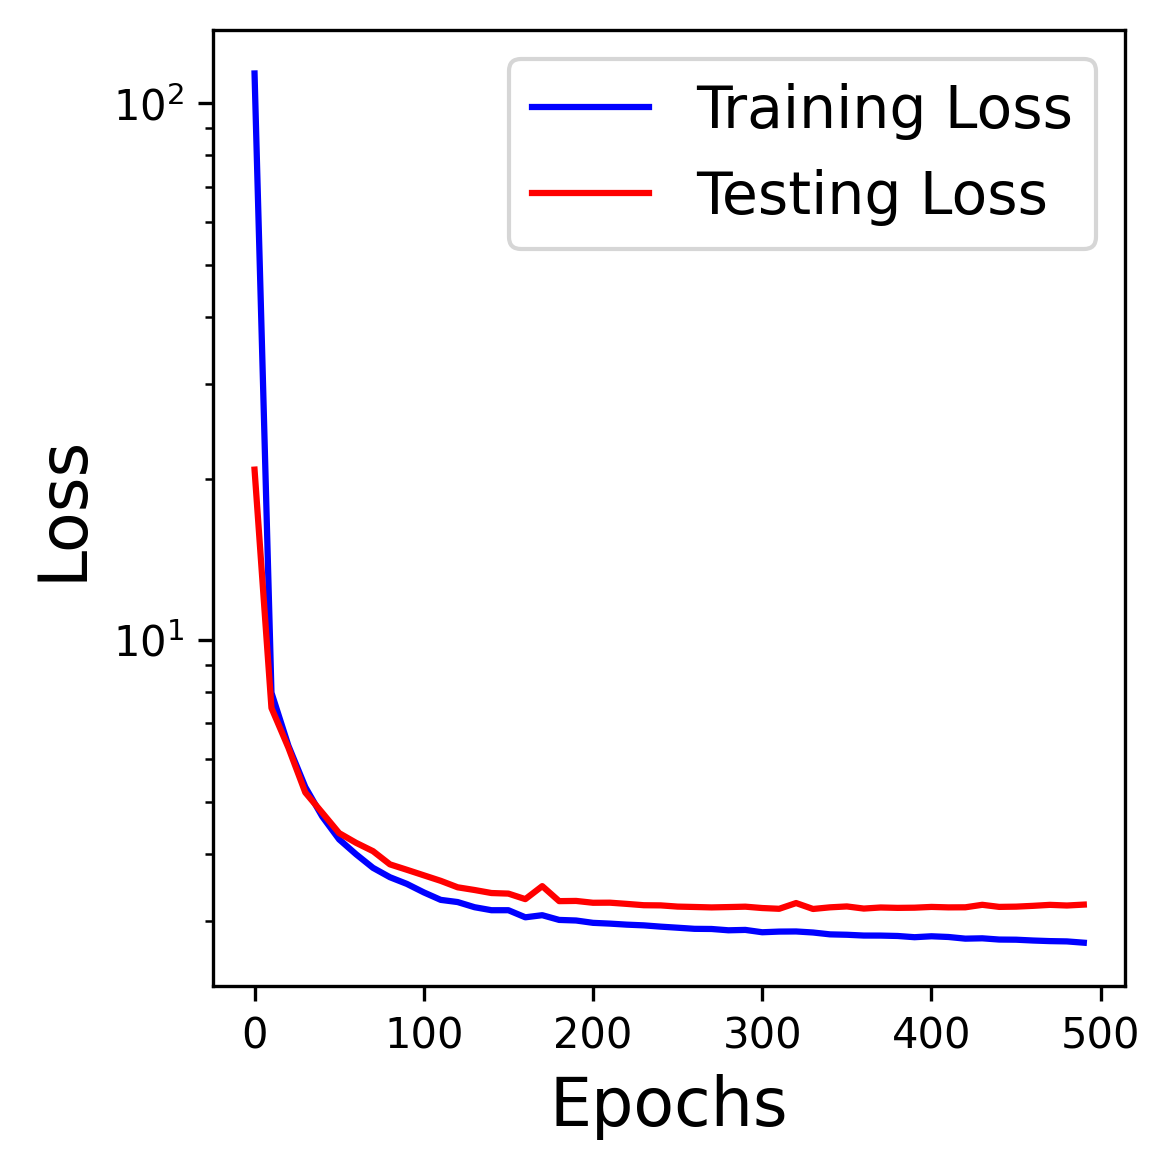

In [ ]:
model = VAE(Ny, Nx, Nt, Nchannel = 1, 
            latent_dim = latent_dim, 
            gamma = gamma,
            lr = lr, 
            mask_t = mask_t, 
            device = device, 
            dtype = dtype)

ts = perf_counter()
train_loss, test_loss = model.train_vae(
                                    nIter = epochs, 
                                    num_print = num_print, 
                                    batch_size = batch_size, 
                                    xtrain = h_train_torch, 
                                    xtest = h_test_torch
                                    )
elps_time = perf_counter() - ts
torch.save(model.encoder.state_dict(), os.path.join(path_f, f'h_encoder_weights_latentdim_{latent_dim}.pth'))
torch.save(model.decoder.state_dict(), os.path.join(path_f, f'h_decoder_weights_latentdim_{latent_dim}.pth'))
torch.save(model.state_dict(), os.path.join(path_f, f'h_vae_weights_latentdim_{latent_dim}.pth'))

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")
print(f'Convolutional VAE Training Time {elps_time:.3f}')
print(f'latent_dim: {latent_dim} \t epochs:{epochs} \t gamma:{gamma} \t lr:{lr}', file = f_rec)
print(f'number of trainables:{total_trainable_params}', file = f_rec)
print(f'Convolutional VAE Training Time {elps_time:.3f}', file = f_rec)
plot_loss(train_loss, test_loss, epochs, num_print, save_fig_to)

Relative L2 error of yref: 8.06e-02
Relative L2 error of Kref: 2.22e-01


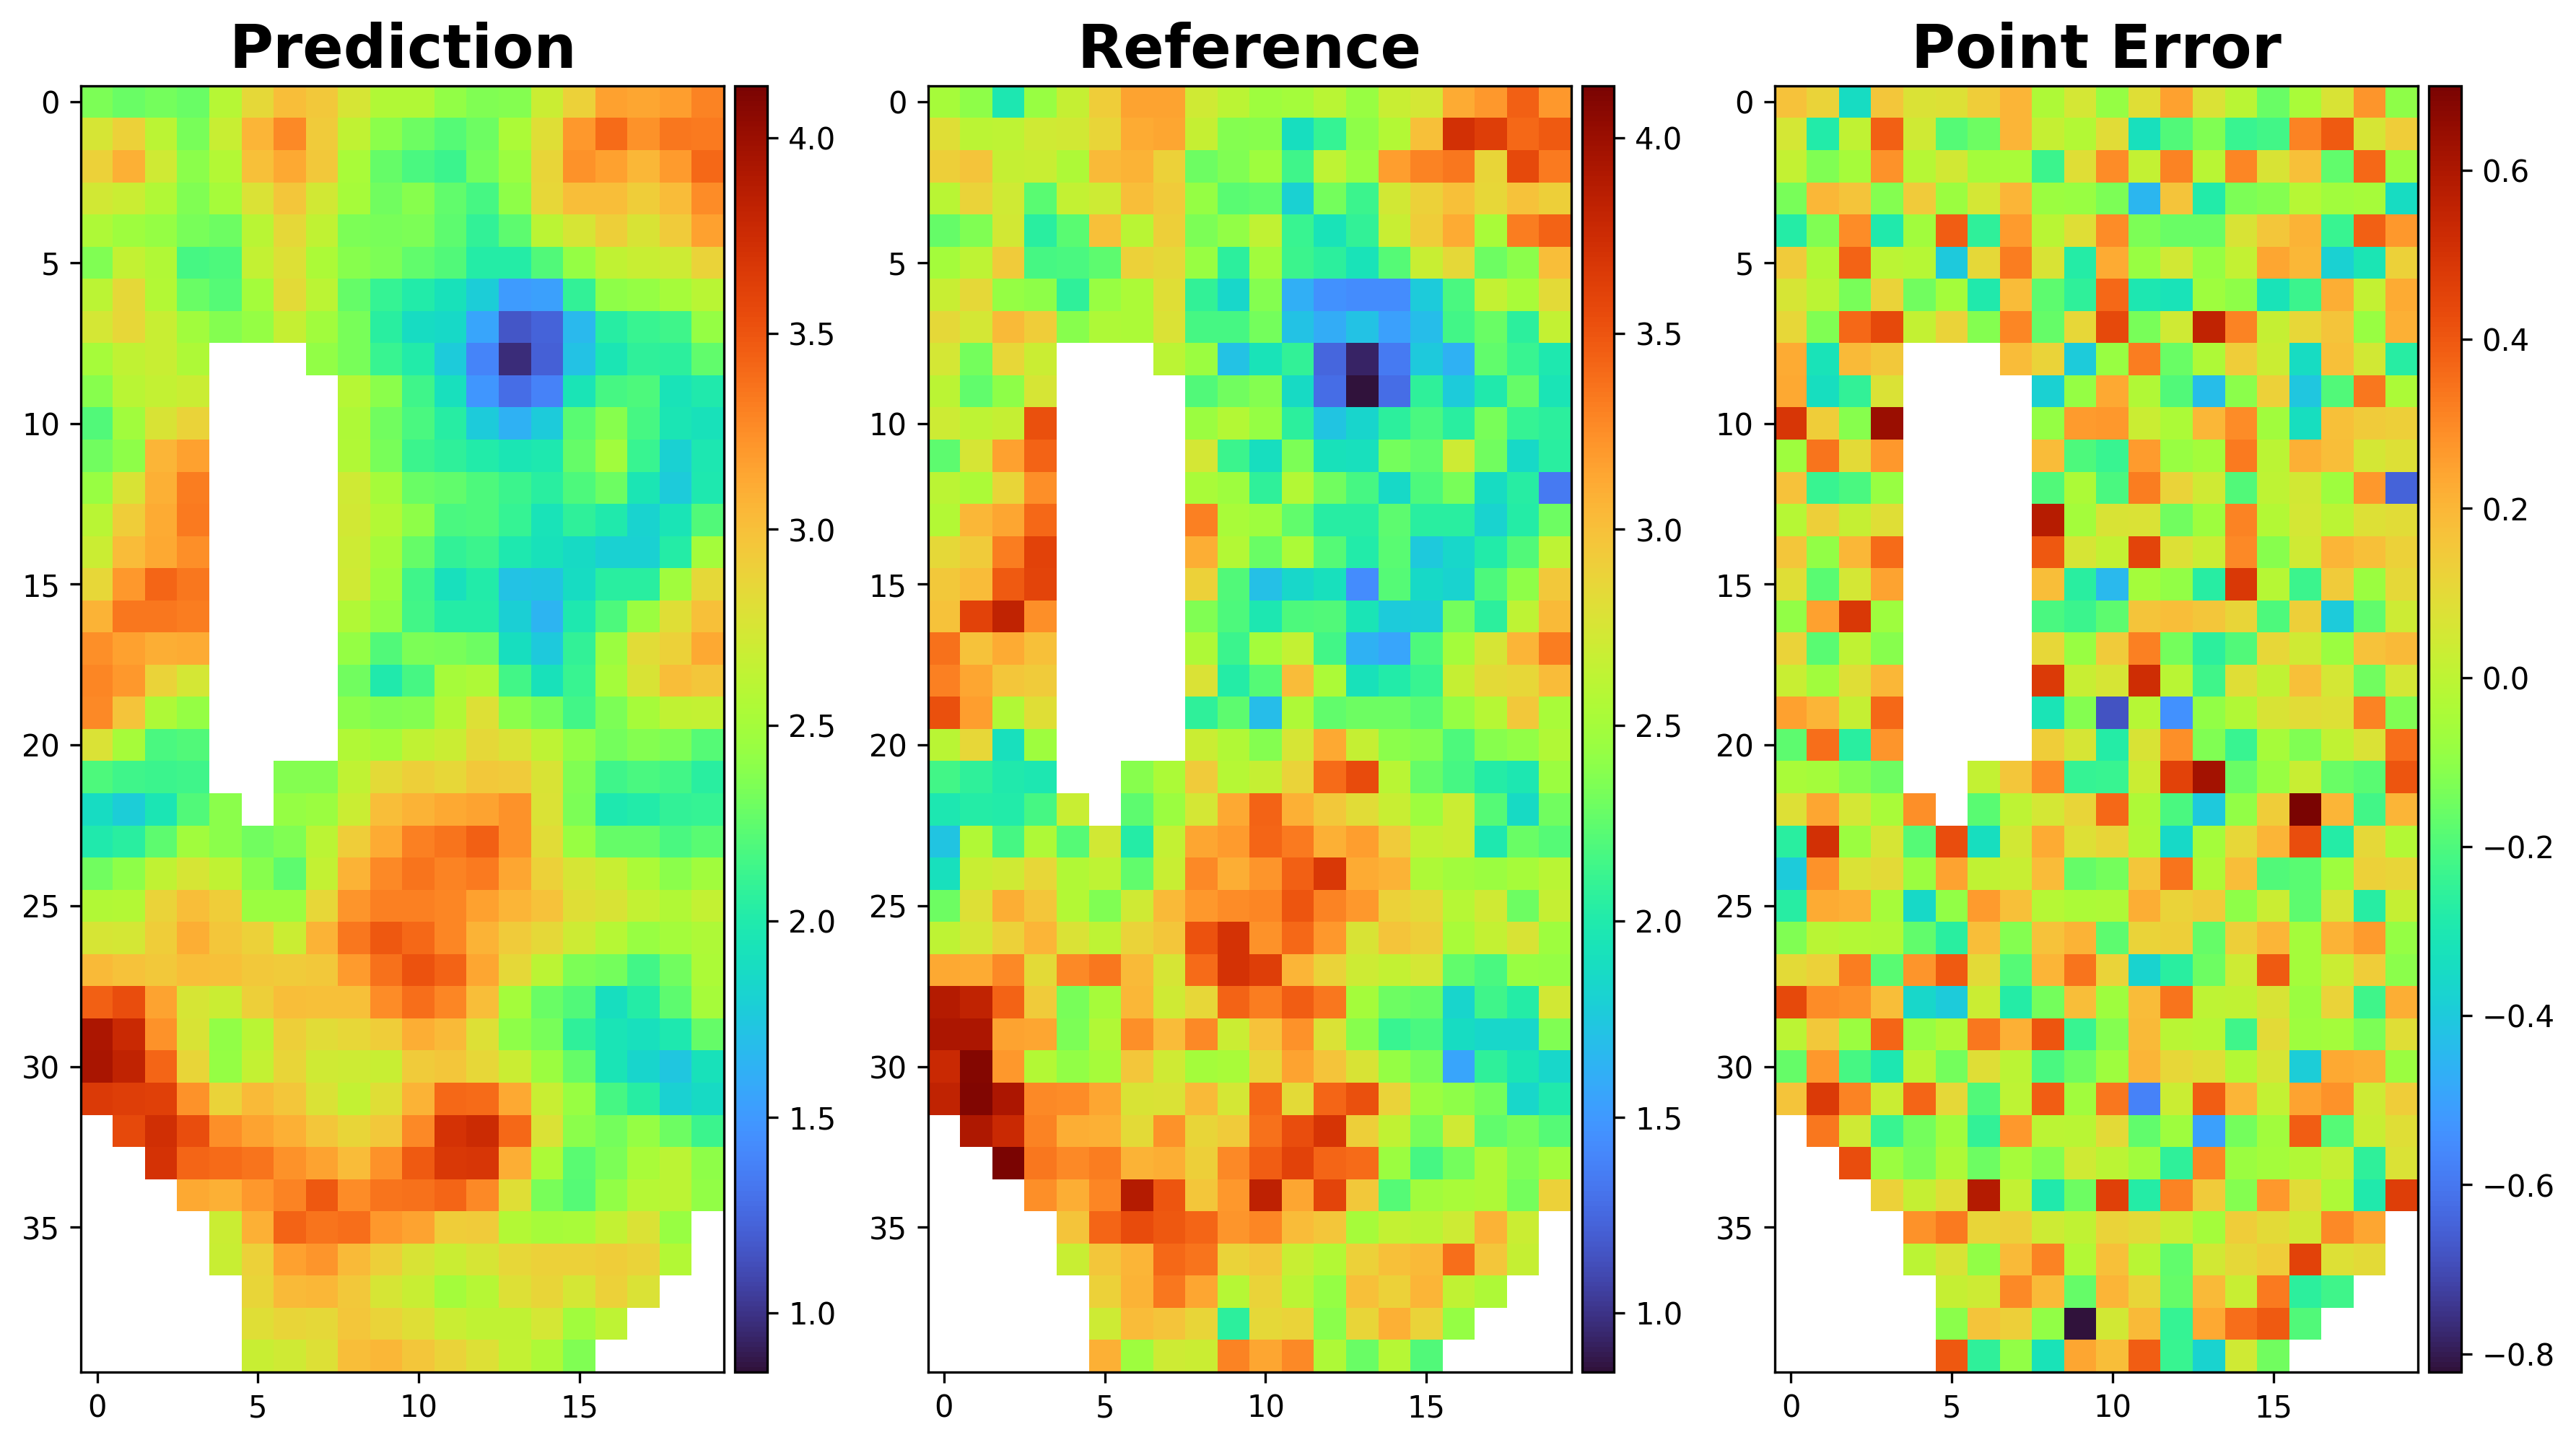

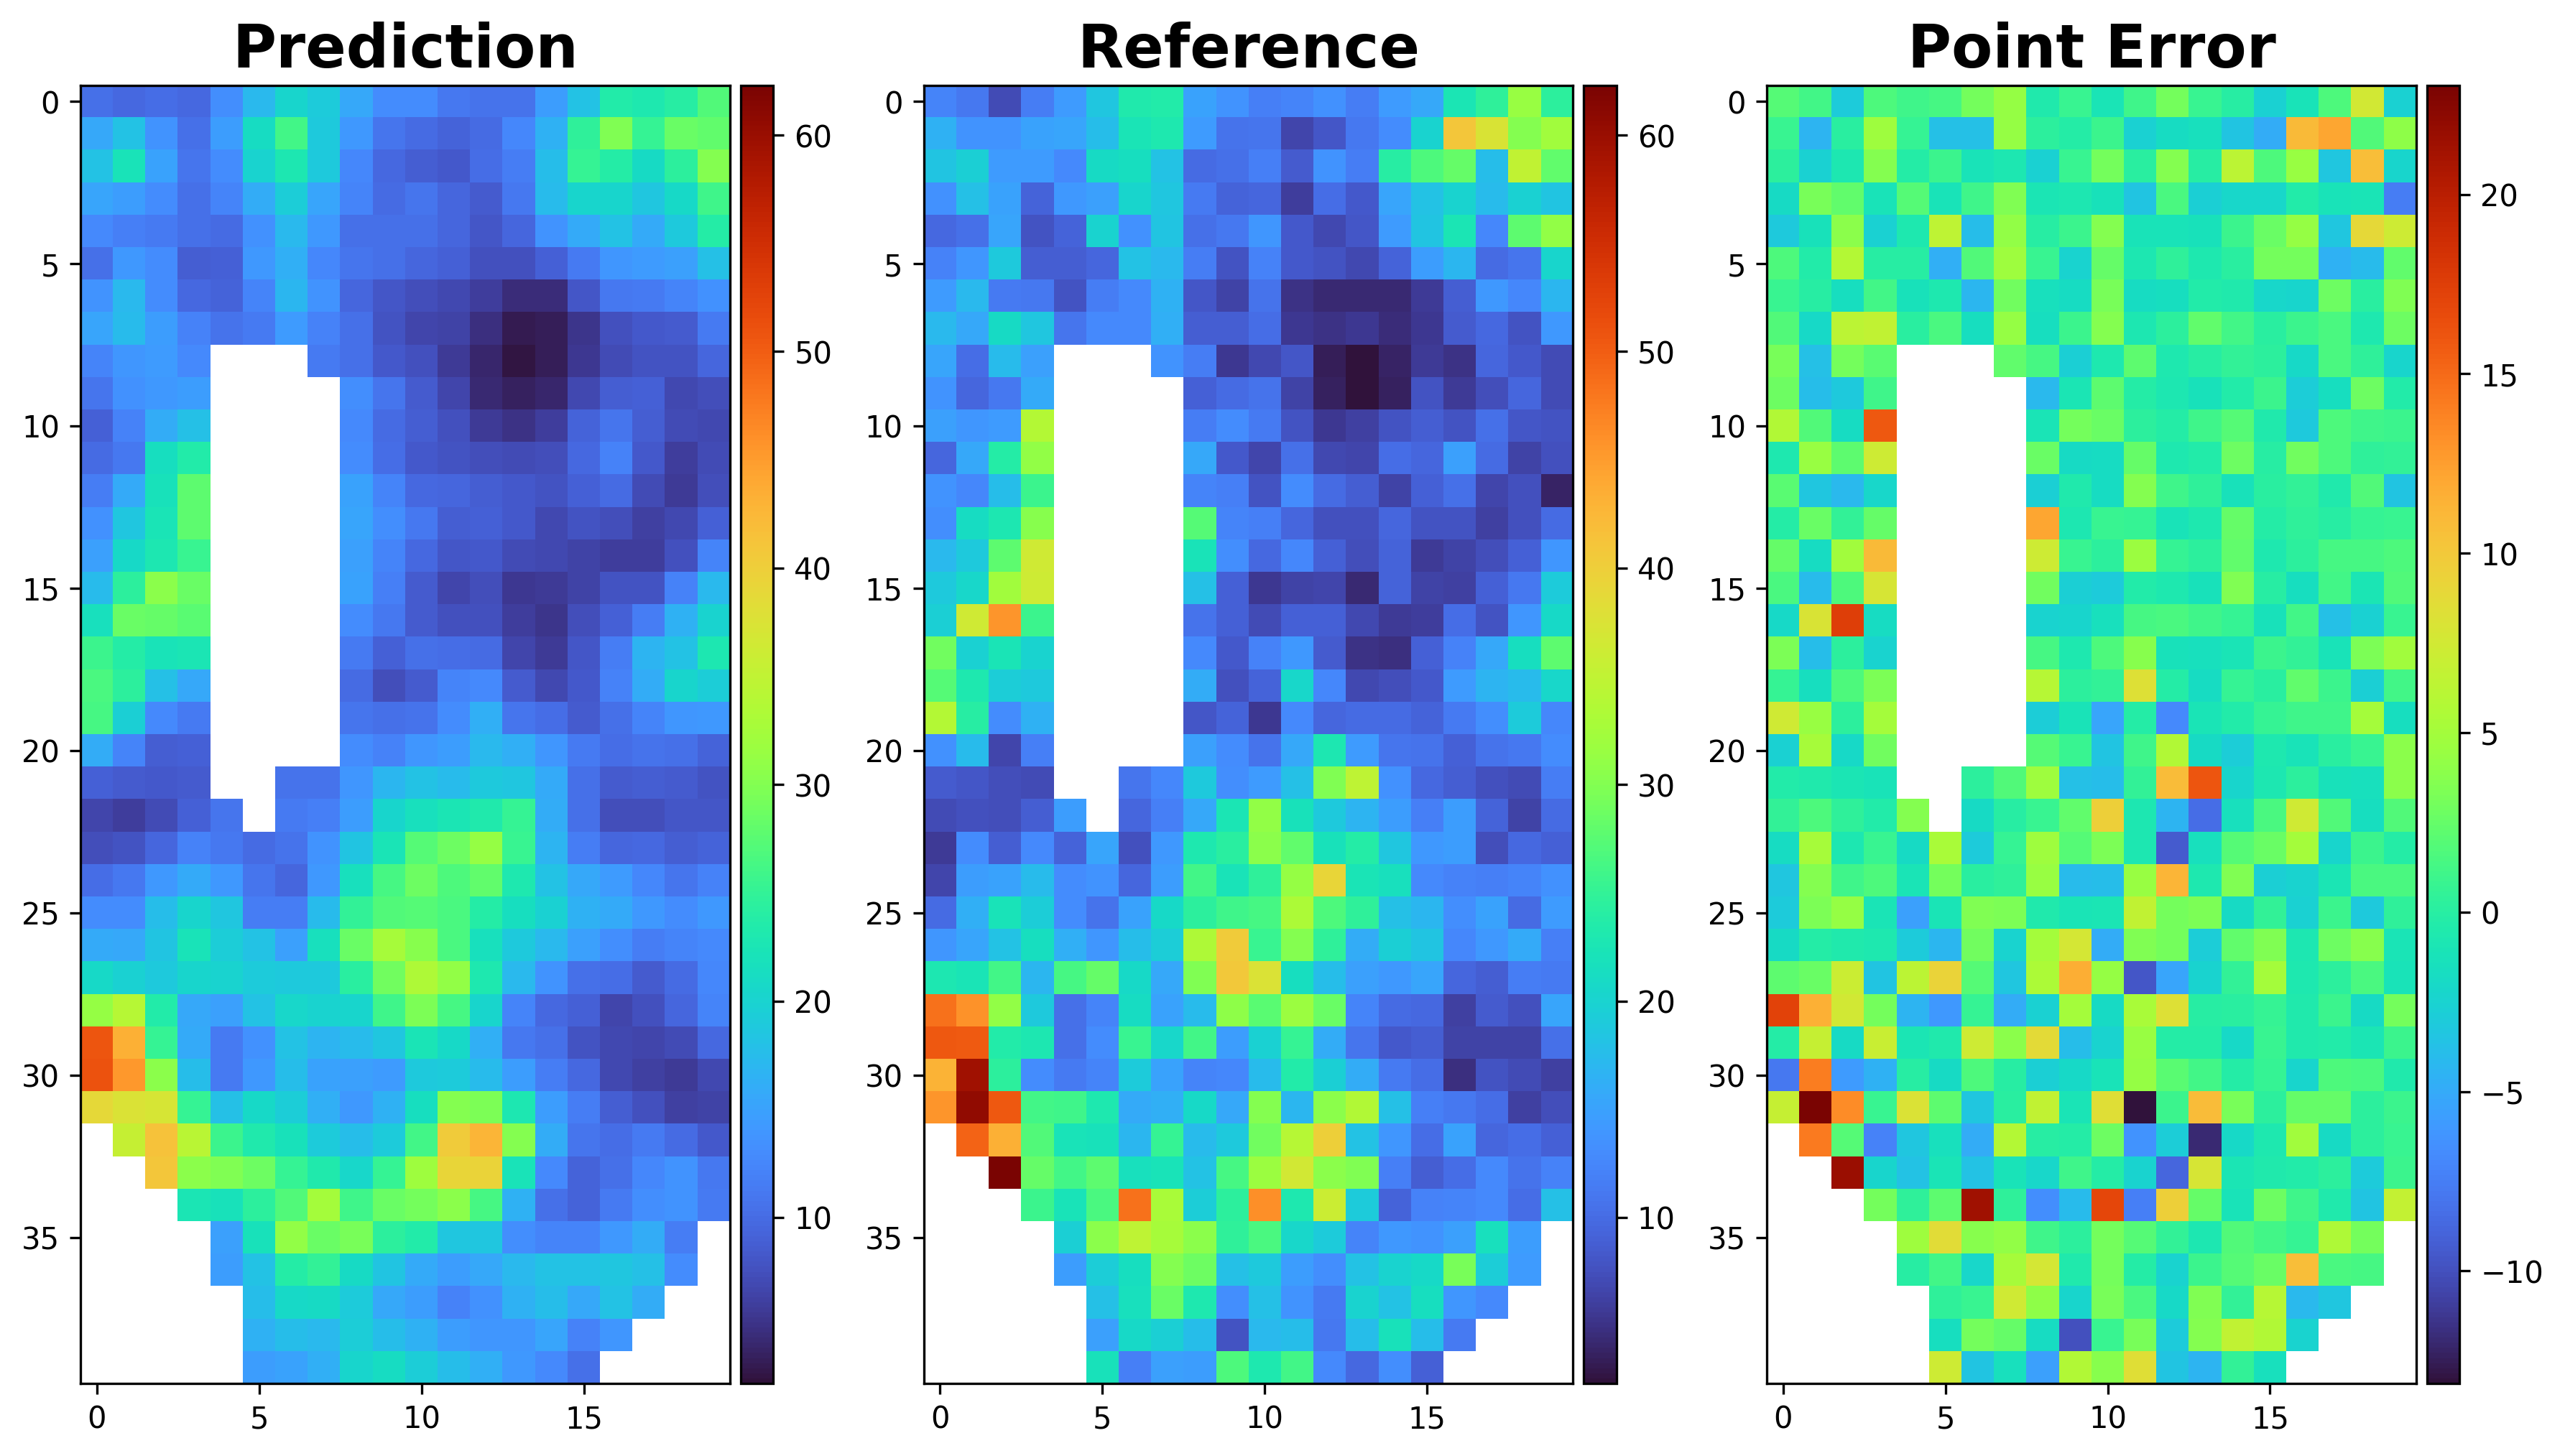

In [ ]:
########### post-analysis #############
mean_z, logvar_z = model.encoder(h_ref_torch)
h_recon = model.decoder(mean_z).detach().cpu().numpy()[0, 0, ...]
h_recon = back_normalize(h_recon, h_train_max, h_train_min)
h_recon_masked = h_recon[mask_t]
h_ref_masked = h_ref[mask_t]
rl2_error = rl2e(h_recon_masked, h_ref_masked)
print('Relative L2 error of href: {:.2e}'.format(rl2_error))
print('Relative L2 error of href: {:.2e}'.format(rl2_error), file=f_rec)
plot_field(h_recon_masked, save_fig_to + 'plot_comparison_href_all_timestep.png', mask_t)
plot_field(np.abs(h_recon_masked - h_ref_masked), save_fig_to + 'plot_comparison_hdiff_all_timestep.png', mask_t) 

In [ ]:
mean_z_test, logvar_z_test = model.encoder(h_test_torch)
np.savetxt(os.path.join(path_f, 'h_test_latent_mean.txt'), mean_z_test.detach().cpu().numpy())
np.savetxt(os.path.join(path_f, 'h_test_latent_std.txt'), torch.exp(0.5 * logvar_z_test).detach().cpu().numpy())
h_recon = model.decoder(mean_z_test).detach().cpu().numpy()[:, 0, ...]
h_recon = back_normalize(h_recon, h_train_max, h_train_min)
h_recon_masked = h_recon[mask_rep_t_batch(h_test)]
h_test_masked = h_test[mask_rep_t_batch(h_test)]
rl2_error = rl2e(h_recon_masked, h_test_masked)
print('Relative L2 error of testing h data: {:.2e}'.format(rl2_error))
print('Relative L2 error of testing h data: {:.2e}'.format(rl2_error), file=f_rec)


In [ ]:
Neta = 150
eta_test = etah[Ntrain : Ntrain + Ntest, :]
eta_ref = etah[-1:, :]
h_kl_test = h_mean + np.einsum('ij,bj-> bi', Psih, xi_test)
h_kl_ref = h_mean + np.einsum('ij,bj-> bi', Psih, xi_ref)
y_ref_masked = y_ref[mask]
y_test_masked = y_test[mask_rep_batch(y_test)]
y_rl2e_ref = rl2e(y_kl_ref, y_ref_masked)
y_rl2e_test = rl2e(y_kl_test.reshape(-1), y_test_masked)
print('Relative L2 error of ykl with yref: {:.2e}'.format(y_rl2e_ref))
print('Relative L2 error of ykl with ytest: {:.2e}'.format(y_rl2e_test))

Relative L2 error of ykl with yref: 7.39e-02
Relative L2 error of ykl with ytest: 8.18e-02


In [ ]:
plot_func(mesh_recon(y_kl_ref), 
          mesh_recon(y_ref_masked), 
          save_fig_to + 'plot_comparison_ykl_yref.png') 

TypeError: mesh_recon() missing 1 required positional argument: 'inactive_mask'